In [91]:
import awkward as ak
import pathlib
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, MultipleLocator, ScalarFormatter, AutoMinorLocator
from scipy.optimize import curve_fit
from scipy import stats
import atlas_mpl_style as ampl
ampl.use_atlas_style()
#from codes.plotting import plot_prettier 
#plot_prettier()

In [92]:
bib = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\output_reco_bib.json"))
nobib = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\output_reco_nobib.json"))

In [93]:
mcp_pt = bib['mcp_pt']
mcp_eta = bib['mcp_eta']
mcp_phi = bib['mcp_phi'] 

status = bib['status']
pdgid = bib['pdgid']

mcp_mu_pt = bib['mcp_mu_pt']
mcp_mu_eta = bib['mcp_mu_eta']
mcp_mu_phi = bib['mcp_mu_phi']

nhits = bib['nhits']
pixel_nhits = bib['pixel_nhits']
pt_res_hits = bib['pt_res_hits']
d0_res = bib['d0_res']
z0_res = bib['z0_res']
track_pt = bib['track_pt']
pt_res = bib['pt_res'] 
pt_match = bib['pt_match'] #THIS IS TRUTH PT
eta_match = bib['eta_match'] #Truth eta
track_eta = bib['track_eta'] #Track eta
theta_match = bib['theta_match']
phi_match = bib['phi_match'] #Track phi
d0_res_match = bib['d0_res_match']
z0_res_match = bib['z0_res_match']
ndf = bib['ndf']
chi2 = bib['chi2']


In [94]:
x = ak.flatten(mcp_eta)
print(len(x[np.abs(x) > 5]))
#print(len(track_eta[np.abs(ak.flatten(track_eta)>1)]))
print(len(ak.flatten(nobib['track_eta'])))
print(len(ak.flatten(bib['track_eta'])))
print(len(ak.flatten(mcp_pt[status==1])))

39
64
227
318


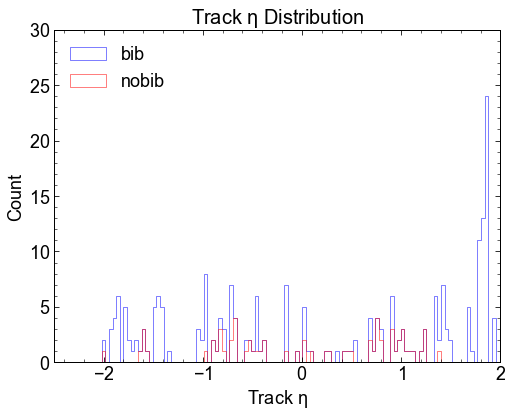

In [95]:
plt.figure(figsize=(8,6))
plt.hist(ak.flatten(bib['track_eta']), bins=np.linspace(-5,6,300), label = "bib", color='blue', histtype = 'step')
plt.hist(ak.flatten(nobib['track_eta']), bins=np.linspace(-5,6,300), label = "nobib", color='red',  histtype = 'step')
plt.xlim(-2.5,2)
plt.xlabel('Track $\eta$')
plt.ylabel('Count')
plt.title('Track $\eta$ Distribution')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()

### Plotting Functions

In [96]:
# Function for creating a Gaussian fit
def gaussian(x, a, mu, sigma):
    return a * np.exp(-0.5 * ((x - mu) / sigma)**2)

def fit_gaussian(slice_data, bins = np.linspace(-0.5,0.5,300), mean = 0, rms = 0.01):
    """
    Fit a Gaussian to the input data slice.

    Parameters:
        slice_data (numpy.ndarray): Input data slice.
        bins (numpy.ndarray, optional): Binning for histogram. Default is np.linspace(-0.5, 0.5, 300).
        mean (float, optional): Mean value for the Gaussian fit. Default is 0.
        rms (float, optional): RMS value for the Gaussian fit. Default is 0.01.

    Returns:
        tuple: Tuple containing fit parameters (popt), covariance matrix (pcov), and bin centers.
    """
    if mean is None:
        mean = np.mean(slice_data)
    if rms is None:
        rms = np.sqrt(np.mean(np.square(slice_data - mean)))
    if bins is None:
        bins = np.linspace(-1,1, 300)
    counts, bin_edges = np.histogram(slice_data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=[max(counts), mean, rms])
    return popt, pcov, bin_centers

##############################################################################################################################################################################################################################
# Function for plotting RMS vs. eta/theta/pT for multiple pT bins

def plotrms_multi(datax, datay, bins, ylim = None, labels=['','',''], xlabel = '', ylabel='', title=''):
    """
    Plot RMS values against eta/theta/pT for multiple pT bins.

    Parameters:
        datax (list of numpy.ndarray): List of x-data arrays.
        datay (list of numpy.ndarray): List of y-data arrays.
        bins (int): Number of bins for the x-data histogram.
        ylim (tuple, optional): Y-axis limits. Default is None.
        labels (list of str, optional): Labels for the data series. Default is None.
        xlabel (str, optional): X-axis label. Default is an empty string.
        ylabel (str, optional): Y-axis label. Default is an empty string.
        title (str, optional): Plot title. Default is an empty string.
    """
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    for j in range(len(datay)):
        data_flatx = np.array(np.ravel(datax[j])).T
        data_flaty = np.array(np.ravel(datay[j])).T
        x_bins = np.linspace(data_flatx.min(), data_flatx.max(), bins + 1)
        rms_values = []
        sem_values = []
        for i in range(bins):
            slice_data = data_flaty[(data_flatx >= x_bins[i]) & (data_flatx < x_bins[i + 1])]
            try:
                # Fit a Gaussian to the slice data using the fit_gaussian function
                popt, pcov, bin_centers = fit_gaussian(slice_data)
                fitted_mean = popt[1]
                fitted_rms = popt[2]
                sem = (np.sqrt(np.diag(pcov)))[2]
            except RuntimeError:
                print(f"Could not fit Gaussian for Slice {i} for pt {j}.")
                rms = np.sqrt(np.mean(np.square(slice_data - np.mean(slice_data))))
                rms_values.append(rms)
                sem_values.append(np.std(slice_data, ddof=1) / np.sqrt(2*(len(slice_data)-1)))
                continue            
            # sem = np.std(slice_data, ddof=1) / np.sqrt(len(slice_data))
            if np.isnan(sem) or sem == 0:
                continue  # Skip bins with zero or NaN standard deviation
            rms_values.append(fitted_rms)
            sem_values.append(sem)
        #print(sem_values)
        ax.errorbar((x_bins[:-1] + x_bins[1:]) / 2, rms_values, xerr = (data_flatx.max()-data_flatx.min())/(2*bins), yerr = sem_values, fmt='o', markersize=4, label=labels[j])#, linestyle='-')
        #ax.scatter((x_bins[:-1] + x_bins[1:]) / 2, rms_values, label=labels[j])#, linestyle='-')
    # title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    # xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]     
    # ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    ax.set_title(title)
    ax.set_xlabel(xlabel)#, fontsize=8)
    ax.set_ylabel(ylabel)#, fontsize=8)
    # ax.set_yscale('log')
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.legend()
    plt.show()

##############################################################################################################################################################################################################################
# Function for plotting RMS vs. eta/theta/pT

def plotrms(datax, datay, bins, label="", xlim=None, ylim=None):
    """
    Plot RMS values against eta/theta/pT.

    Parameters:
        datax (numpy.ndarray): x-data array.
        datay (numpy.ndarray): y-data array.
        bins (int): Number of bins for the x-data histogram.
        label (str, optional): Plot labels (title, xlabel, ylabel), split by semicolons. Default is an empty string.
        xlim (tuple, optional): X-axis limits. Default is None.
        ylim (tuple, optional): Y-axis limits. Default is None.
    """
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    
    if xlim is not None:
        x_bins = np.linspace(xlim[0], xlim[1], bins + 1)
    else:
        x_bins = np.linspace(data_flatx.min(), data_flatx.max(), bins + 1)
    
    rms_values = []
    sem_values = []
    
    for i in range(bins):
        # Select data points within the specified x slice
        slice_data = data_flaty[(data_flatx >= x_bins[i]) & (data_flatx < x_bins[i + 1])]
        #print("Bin", i, "has", len(slice_data), "data points")
        try:
            popt, pcov, bin_centers = fit_gaussian(slice_data)
            fitted_mean = popt[1]
            fitted_rms = popt[2]
            sem_values.append(np.sqrt(pcov[2, 2]))
            rms_values.append(fitted_rms)
        except RuntimeError:
            print(f"Could not fit Gaussian for Slice {i}.")
            rms_values.append(np.sqrt(np.mean(np.square(slice_data - np.mean(slice_data)))))
            sem_values.append(np.std(slice_data, ddof=1) / np.sqrt(len(slice_data)))
            continue
        
        #print(f"Iteration {i}, rms_values size: {len(rms_values)}, sem_values size: {len(sem_values)}")

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)

    ax.errorbar((x_bins[:-1] + x_bins[1:]) / 2, rms_values, yerr = sem_values, xerr = (data_flatx.max()-data_flatx.min())/(2*bins), color = 'darkblue', fmt='o', markersize=4)#, linestyle='-')
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]     
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    ax.set_title(title)
    ax.set_xlabel(xlabel)#, fontsize=8)
    ax.set_ylabel(ylabel)#, fontsize=8)
    ax.set_yscale('log')
    if ylim is not None:
            ax.set_ylim(ylim[0], ylim[1])
    plt.show()

##############################################################################################################################################################################################################################
# Function for plotting a 1D histogram and fitting a Gaussian to it

def plotrms_slice(datax, datay, x_bins, bins=None, xlim = None, title="", rv = False, sigma5 = False):
    """
    Plot a 1D histogram and fit a Gaussian to it for a specified x-slice.

    Parameters:
        datax (numpy.ndarray): x-data array.
        datay (numpy.ndarray): y-data array.
        x_bins (numpy.ndarray): Binning for the x-slice.
        bins (numpy.ndarray, optional): Binning for histogram. Default is None.
        xlim (tuple, optional): X-axis limits. Default is None.
        title (str, optional): Plot title. Default is an empty string.
        rv (bool, optional): Return fitted RMS and mean. Default is False.
        sigma5 (bool, optional): Plot sigma-5 lines. Default is False.

    Returns:
        list: List containing fitted RMS and mean if rv=True and a Gaussian fit was successful; otherwise [0, 0].
    """
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    for i in range(len(x_bins)-1):
        # Select data points within the specified x slice
        slice_data = data_flaty[(data_flatx >= x_bins[i]) & (data_flatx < x_bins[i + 1])]
        gaussian_fit = True
        try:
            # Fit a Gaussian to the slice data using the fit_gaussian function
            popt, pcov, bin_centers = fit_gaussian(slice_data, bins=bins, mean = None, rms = None)
            fitted_mean = popt[1]
            fitted_rms = popt[2]
            # Print the values
            print(f"Slice {i}:", x_bins[i], 'to', x_bins[i + 1])
            #print("Actual Mean:", actual_mean)
            print("Mean from Fit:", fitted_mean)
            #print("Actual RMS:", actual_rms)
            print("Sigma from Fit:", fitted_rms)
            print("------------------------------------")
        except:
            print(f"Could not fit Gaussian for Slice {i}.")
            gaussian_fit = False
        # Plot the 1D histogram with the Gaussian fit
        plt.hist(slice_data, bins, alpha=0.5, label='Data')
        if gaussian_fit:
            plt.plot(bin_centers, gaussian(bin_centers, *popt), 'r--', label='Gaussian Fit')
            if sigma5 == True:
                plt.axvline(x=fitted_mean - 5*np.abs(fitted_rms), linestyle='dotted', color='green', label=f'-5$\sigma$ = {fitted_mean - 5*np.abs(fitted_rms)}')
                plt.axvline(x=fitted_mean + 5*np.abs(fitted_rms), linestyle='dotted', color='green', label=f'+5$\sigma$ = {fitted_mean + 5*np.abs(fitted_rms)}')
        plt.ylabel('Counts')
        plt.xlabel(title, fontsize = 22)#+ f' for Slice {i}')
        if xlim is not None:
            plt.xlim(xlim)
        #plt.yscale('log')
        plt.legend()
        plt.show()
        if gaussian_fit:
            if rv == True:
                return fitted_rms, fitted_mean
        else:
            return [0,0]
##############################################################################################################################################################################################################################
# 2D Histogram plotting function

def plot2DHistogram(datax, datay, bins=100, weights = None, norm="log", label="", xlim = None, ylim = None, stats = False):
    """
    Plot a 2D histogram.

    Parameters:
        datax (numpy.ndarray): x-data array.
        datay (numpy.ndarray): y-data array.
        bins (int, optional): Number of bins for the 2D histogram. Default is 100.
        norm (str, optional): Normalization for the color map. Default is "log".
        label (str, optional): Plot labels (title, xlabel, ylabel), split by semicolons. Default is an empty string.
        xlim (tuple, optional): X-axis limits. Default is None.
        ylim (tuple, optional): Y-axis limits. Default is None.
        stats (bool, optional): Display statistics. Default is False.
    """
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    
    if weights is not None:
        values = np.array(np.ravel(weights)).T
    else:
        values = None

    fig = plt.figure(figsize=(4.5,3))
    ax = fig.add_subplot(111)

    hh = ax.hist2d(data_flatx, data_flaty, bins=bins, weights = values, norm=norm, cmap="viridis")
    
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2]  
    zlabel = "" if len(label.split(";")) < 4 else label.split(";")[3] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)#, fontsize=8)
    ax.set_ylabel(ylabel)#, fontsize=8)
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

    if stats == True:
        # Calculate statistics
        num_entries = len(data_flatx)
        mean_x = np.mean(data_flatx)
        mean_y = np.mean(data_flaty)
        std_x = np.std(data_flatx)
        std_y = np.std(data_flaty)
        # Calculate FWHM of datay
        #fwhm_value = fwhm(data_flaty, bins = np.linspace(np.min(data_flaty), np.max(data_flaty), bins[1]))
        
        # Create a text box to display statistics
        # stats_text = 'FWHM '+ylabel+f':{fwhm_value:.3f}'#"Entries: {num_entries}\nMean x: {mean_x:.2f}\nMean y: {mean_y:.2f}\nStd Dev x: {std_x:.2f}\nStd Dev y: {std_y:.2f}"
        # ax.text(0.5, 0.98, stats_text, transform=ax.transAxes, va='top', ha='left', bbox=dict(boxstyle='round, pad=0.5', facecolor='white', alpha=0.8), fontsize = 7)

    # colorbars are annoying
    cbar = fig.colorbar(hh[3])
    #cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.set_label(zlabel)#, fontsize=6)

    plt.show()

##############################################################################################################################################################################################################################
# 2D Scatter plot function
def plot2Dscatter(datax, datay, label_numbers=None, xlim=None, ylim=None, labels=""):
    """
    Plot a scatter plot with the option to label each data point with numbers.

    Parameters:
        data_x (numpy.ndarray): x-data array.
        data_y (numpy.ndarray): y-data array.
        label_numbers (numpy.ndarray, optional): Array of numbers for labeling each data point. Default is None.
        xlim (tuple, optional): X-axis limits. Default is None.
        ylim (tuple, optional): Y-axis limits. Default is None.
        labels (str, optional): Plot labels (title, xlabel, ylabel), split by semicolons. Default is an empty string.
        show_stats (bool, optional): Display statistics. Default is False.
    """
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    
    if label_numbers is not None:
        label_numbers = np.array(np.ravel(label_numbers)).T
    else:
        values = None

    fig, ax = plt.subplots(figsize=(4.5, 3))

    scatter = ax.scatter(data_flatx, data_flaty, c='blue', s=20)

    title = "" if len(labels.split(";")) < 1 else labels.split(";")[0]
    x_label = "" if len(labels.split(";")) < 2 else labels.split(";")[1]
    y_label = "" if len(labels.split(";")) < 3 else labels.split(";")[2]

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

    if label_numbers is not None:
        # Annotate each point with its number label
        for num, x, y in zip(label_numbers, data_flatx, data_flaty):
            ax.annotate(str(num), (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
    #plt.legend()
    plt.show()

##############################################################################################################################################################################################################################
# 1D Histogram comparison function

colors = []
def compare1DHistograms(datas,bins,scale='linear',label="",leg=[]):
    """
    Compare multiple 1D histograms.

    Parameters:
        datas (list of numpy.ndarray): List of data arrays to compare.
        bins (int): Number of bins for the histograms.
        scale (str, optional): Y-axis scale. Default is 'linear'.
        label (str, optional): Plot label. Default is an empty string.
        leg (list of str, optional): Legend labels for each data series. Default is an empty list.
    """
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)
    
    for i,data in enumerate(datas): 
        if len(data) != 0:
            # handle data, there must be a smarter way to do this...
            if type(data[0])==np.int64   : data_flat=data
            elif type(data[0])==np.float32 : data_flat=data
            else : data_flat = ak.flatten(data, axis=None)
            
            ax.hist(data_flat, bins, alpha=1, label=leg[i] if len(leg)>i else "", histtype = 'step')
        else:
            print("No data for histogram",i)
            continue
   
    # handle labels
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    plt.legend()
    plt.yscale(scale)
    plt.show()

In [97]:
print(np.max(ak.flatten(mcp_eta)))
print(len(ak.flatten(bib['phi_match'])))
print(len(ak.flatten(bib['track_eta'])))
print(mcp_eta[0][status[0]== 1])
print(len(ak.flatten(nobib['mcp_eta'])))

100000000000.0
227
227
[3, -3.93, -0.824, -0.432, -0.393, -2.31, ..., 0.882, 0.25, 0.279, 0.7, 0.623]
36832


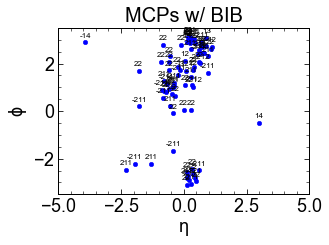

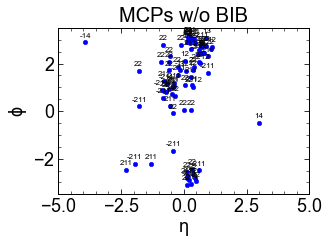

In [98]:

plot2Dscatter((mcp_eta[0][status[0] == 1]), (mcp_phi[0][status[0] == 1]), label_numbers = (pdgid[0][status[0] == 1]), labels=r"MCPs w/ BIB;$\eta$;$\phi$", xlim = (-5,5), ylim = (-3.5,3.5))
plot2Dscatter((nobib['mcp_eta'][0][nobib['status'][0] == 1]), (nobib['mcp_phi'][0][nobib['status'][0] == 1]), label_numbers = (nobib['pdgid'][0][nobib['status'][0] == 1]), labels=r"MCPs w/o BIB;$\eta$;$\phi$", xlim = (-5,5), ylim = (-3.5,3.5))



### Plot 2D Hists showing resolution against $p_T$/$\eta$ and then the RMS of them against $\eta$

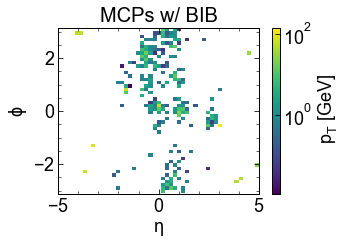

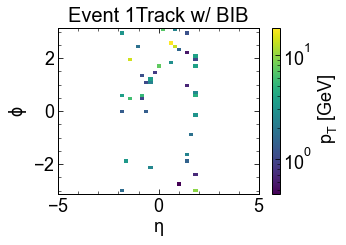

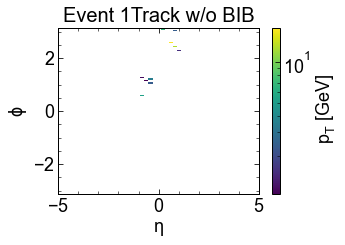

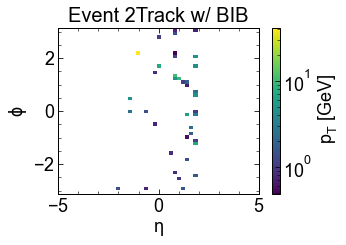

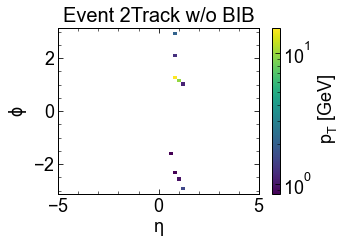

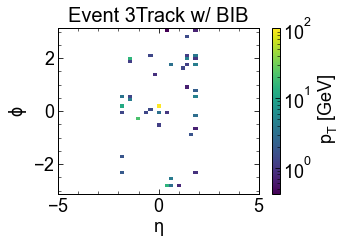

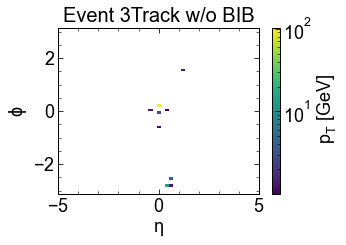

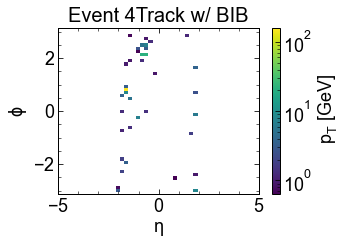

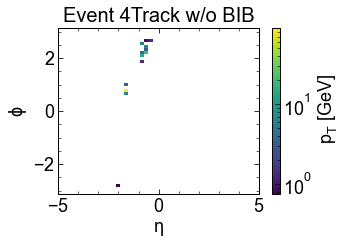

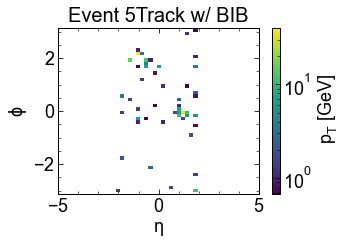

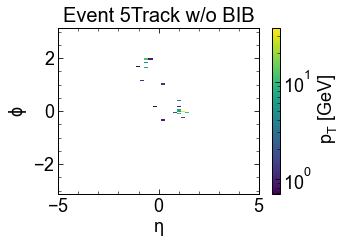

In [28]:
pt_250_1000 = [250,1000]
plot2DHistogram((mcp_eta[status == 1]), (mcp_phi[status == 1]), bins=(np.linspace(-5,5,50),50), weights = (mcp_pt[status == 1]), label=r"MCPs w/ BIB;$\eta$;$\phi$; $p_T$ [GeV]", xlim = (-5,5), ylim = (-3.14,3.14))

x = 0
while x < 5:
    plot2DHistogram((track_eta[x]), (phi_match[x]), bins=(np.linspace(-5,5,50),50 ), weights = (track_pt[x]), label=r"Event " + str(x+1) + r"Track w/ BIB;$\eta$;$\phi$; $p_T$ [GeV]", xlim = (-5,5), ylim = (-3.14,3.14))
    plot2DHistogram((nobib['track_eta'][x]), (nobib['phi_match'][x]), bins=(np.linspace(-5,5,50),50 ), weights = (nobib['track_pt'][x]), label=r"Event " + str(x+1) + r"Track w/o BIB;$\eta$;$\phi$; $p_T$ [GeV]", xlim = (-5,5), ylim = (-3.14,3.14))
    x+=1



### Misc. Studies

<Figure size 432x288 with 0 Axes>

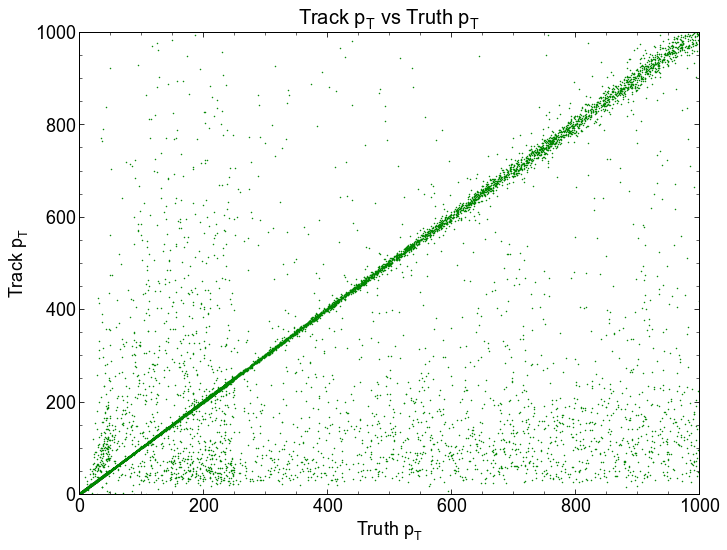

In [18]:
#from importlib import reload
#plt=reload(plt)
total_truth_pt = ak.concatenate([pt_0_50['mcp_mu_pt'], pt_50_250['mcp_mu_pt'], pt_250_1000['mcp_mu_pt']], axis=0)
total_track_pt = ak.concatenate([pt_0_50['pt_match'], pt_50_250['pt_match'], pt_250_1000['pt_match']], axis=0)  # this is also truth pt but only for muons that have a matched track associated with them
total_track_eta = ak.concatenate([pt_0_50['eta_match'], pt_50_250['eta_match'], pt_250_1000['eta_match']], axis=0)
total_truth_eta = ak.concatenate([pt_0_50['mcp_mu_eta'], pt_50_250['mcp_mu_eta'], pt_250_1000['mcp_mu_eta']], axis=0)
total_truth_phi = ak.concatenate([pt_0_50['mcp_mu_phi'], pt_50_250['mcp_mu_phi'], pt_250_1000['mcp_mu_phi']], axis=0)
total_track_phi = ak.concatenate([pt_0_50['phi_match'], pt_50_250['phi_match'], pt_250_1000['phi_match']], axis=0)
total_nhits = np.ravel(ak.concatenate([pt_0_50['nhits'], pt_50_250['nhits'], pt_250_1000['nhits']], axis=0))
total_pixel_nhits = np.ravel(ak.concatenate([pt_0_50['pixel_nhits'], pt_50_250['pixel_nhits'], pt_250_1000['pixel_nhits']], axis=0))
ttt = ak.concatenate([pt_0_50['track_pt'], pt_50_250['track_pt'], pt_250_1000['track_pt']], axis=0)  # just using for truth pt vs track pt below
total_pt_res = ak.concatenate([pt_0_50['track_pt'], pt_50_250['track_pt'], pt_250_1000['track_pt']], axis=0)

bib_truth_pt = ak.concatenate([bib_0_50['mcp_mu_pt'], bib_50_250['mcp_mu_pt'], bib_250_1000['mcp_mu_pt']], axis=0)
bib_track_pt = ak.concatenate([bib_0_50['LC_pt_match'], bib_50_250['LC_pt_match'], bib_250_1000['LC_pt_match']], axis=0)  # this is also truth pt but only for muons that have a matched track associated with them
bib_track_eta = ak.concatenate([bib_0_50['LC_eta_match'], bib_50_250['LC_eta_match'], bib_250_1000['LC_eta_match']], axis=0)
bib_truth_eta = ak.concatenate([bib_0_50['mcp_mu_eta'], bib_50_250['mcp_mu_eta'], bib_250_1000['mcp_mu_eta']], axis=0)
bib_truth_phi = ak.concatenate([bib_0_50['mcp_mu_phi'], bib_50_250['mcp_mu_phi'], bib_250_1000['mcp_mu_phi']], axis=0)
bib_track_phi = ak.concatenate([bib_0_50['LC_phi_match'], bib_50_250['LC_phi_match'], bib_250_1000['LC_phi_match']], axis=0)
bib_nhits = np.ravel(ak.concatenate([bib_0_50['LC_nhits'], bib_50_250['LC_nhits'], bib_250_1000['LC_nhits']], axis=0))
#bib_pixel_nhits = np.ravel(ak.concatenate([bib_0_50['pixel_nhits'], bib_50_250['pixel_nhits'], bib_250_1000['pixel_nhits']], axis=0))
bib_pt_res = ak.concatenate([bib_0_50['LC_pt_res'], bib_50_250['LC_pt_res'], bib_250_1000['LC_pt_res']], axis=0)


plt.figure(figsize=(6,4))
plt.subplots(1,1)
plt.scatter(np.ravel(total_track_pt), np.ravel(ttt), s=1)
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.title("Track $p_T$ vs Truth $p_T$")
plt.xlabel("Truth $p_T$")
plt.ylabel("Track $p_T$")
plt.show()

In [24]:
print(len(ak.flatten(bib['track_pt'][bib['track_pt']<20]))/len(ak.flatten(bib['track_pt'])))
print(len(ak.flatten(nobib['track_pt'][nobib['track_pt']<20]))/len(ak.flatten(nobib['track_pt'])))

0.9647577092511013
0.921875


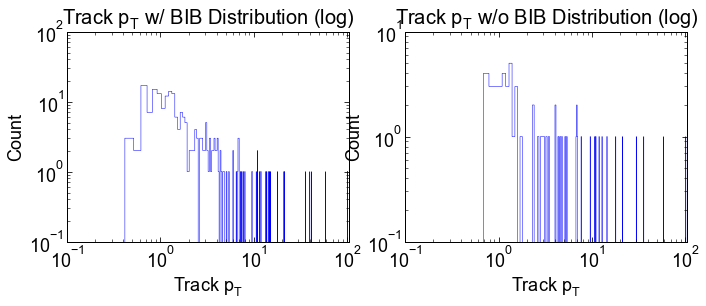

In [39]:
# Histogram for track pt
plt.subplot(2, 2, 1)
plt.hist(ak.flatten(bib['track_pt']), bins=1000, color='blue', histtype = 'step')
plt.xlim(0.1,105)
plt.xlabel('Track $p_T$')
plt.ylabel('Count')
plt.title('Track $p_T$ w/ BIB Distribution (log)')
plt.yscale('log')
plt.xscale('log')


plt.subplot(2, 2, 2)
plt.hist(ak.flatten(nobib['track_pt']), bins=1000, color='blue', histtype = 'step')
plt.xlim(0.1,105)
plt.xlabel('Track $p_T$')
plt.ylabel('Count')
plt.title('Track $p_T$ w/o BIB Distribution (log)')
plt.yscale('log')
plt.xscale('log')


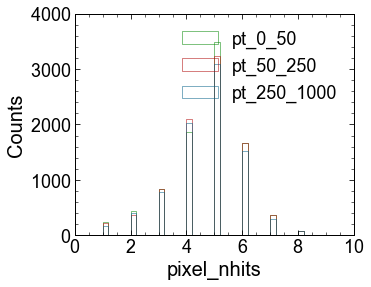

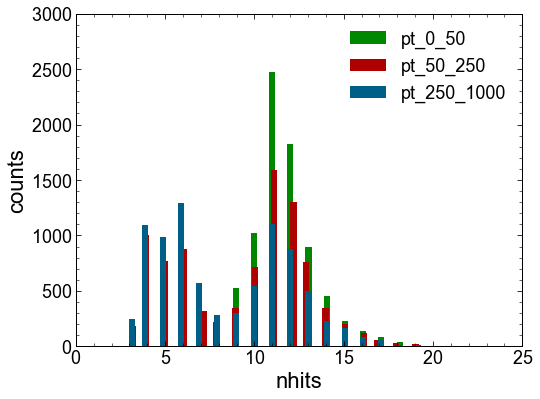

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


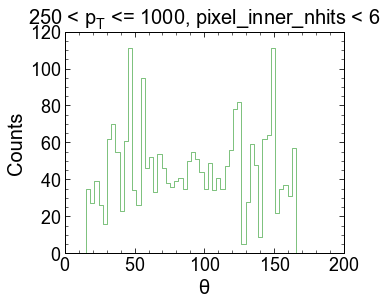

In [68]:
compare1DHistograms([np.ravel(merged['LC_pixel_nhits'][np.ravel(merged['LC_pt_match']) <= 50]),
                    np.ravel(merged['LC_pixel_nhits'][(np.ravel(merged['LC_pt_match']) > 50) & (np.ravel(merged['LC_pt_match']) <= 250)]),
                    np.ravel(merged['LC_pixel_nhits'][np.ravel(merged['LC_pt_match'] > 250)])],
                   bins=40, label=";pixel_nhits;Counts",
                   leg=["pt_0_50", "pt_50_250", "pt_250_1000"])
plt.figure(figsize=(8,6))
plt.hist(np.ravel(merged['LC_nhits'][np.ravel(merged['LC_pt_match']) <= 50]), bins = 50, label = "pt_0_50")
plt.hist(np.ravel(merged['LC_nhits'][(np.ravel(merged['LC_pt_match']) > 50) & (merged['LC_pt_match'] <= 250)]), bins = 50, label = "pt_50_250")
plt.hist(np.ravel(merged['LC_nhits'][np.ravel(merged['LC_pt_match'] > 250)]), bins = 50, label = "pt_250_1000")
#plt.hist(np.ravel(merged['fake_nhits']), bins = 50, label = "Fake")
plt.legend()
plt.xlabel("nhits", fontsize = 22)
plt.ylabel("counts", fontsize = 22)
plt.show()

compare1DHistograms([np.ravel(LC_theta_match[np.ravel(LC_pt_match > 250) & np.ravel(LC_nhits < 6)])],
                   bins=50, label=r"250 < $p_T$ <= 1000, pixel_inner_nhits < 6 ;$\theta$;Counts",)


#plot2DHistogram(total_track_eta, total_pixel_inner_nhits, bins=(100,100), label=r"pixel pixel_inner_nhits v. $\eta$; $\eta$;pixel_inner_nhits")



In [28]:
print("% of bib_250_1000; 50_250; 0_50 w/ nhits")
for i in range(2,15):
    print("<", i, ":", len([True for x in np.ravel(bib_250_1000['nhits']) if x < i])*100/len(bib_250_1000['nhits']), ";", len([True for x in np.ravel(bib_50_250['nhits']) if x < i])*100/len(bib_50_250['nhits']), ";", len([True for x in np.ravel(bib_0_50['nhits']) if x < i])*100/len(bib_0_50['nhits']), "%")


% of bib_250_1000; 50_250; 0_50 w/ nhits
< 2 : 0.0 ; 0.0 ; 0.0 %
< 3 : 0.0 ; 0.0 ; 0.0 %
< 4 : 0.7604562737642585 ; 0.7067137809187279 ; 0.34305317324185247 %
< 5 : 6.083650190114068 ; 3.0035335689045937 ; 1.0291595197255574 %
< 6 : 11.977186311787072 ; 6.890459363957597 ; 1.8867924528301887 %
< 7 : 19.20152091254753 ; 10.070671378091873 ; 2.229845626072041 %
< 8 : 24.524714828897338 ; 12.897526501766784 ; 2.9159519725557463 %
< 9 : 27.566539923954373 ; 14.487632508833922 ; 6.861063464837049 %
< 10 : 33.07984790874525 ; 19.964664310954063 ; 12.864493996569468 %
< 11 : 40.874524714828894 ; 28.79858657243816 ; 24.528301886792452 %
< 12 : 67.30038022813689 ; 62.19081272084806 ; 58.490566037735846 %
< 13 : 88.02281368821293 ; 84.09893992932862 ; 81.81818181818181 %
< 14 : 94.48669201520913 ; 91.87279151943463 ; 91.59519725557462 %


In [29]:
print("% of noBIB_250_1000; 50_250; 0_50 w/ nhits")
for i in range(2,15):
    print("<", i, ":", len([True for x in np.ravel(pt_250_1000['nhits']) if x < i])*100/len(pt_250_1000['nhits']), ";", len([True for x in np.ravel(pt_50_250['nhits']) if x < i])*100/len(pt_50_250['nhits']), ";", len([True for x in np.ravel(pt_0_50['nhits']) if x < i])*100/len(pt_0_50['nhits']), "%")


% of noBIB_250_1000; 50_250; 0_50 w/ nhits
< 2 : 0.0 ; 0.0 ; 0.0 %
< 3 : 0.6620146716765074 ; 0.5825908156271419 ; 0.11796427367711493 %
< 4 : 4.061549472177491 ; 3.050034270047978 ; 0.6740815638692281 %
< 5 : 10.395419574163535 ; 8.156271418779987 ; 2.0222446916076846 %
< 6 : 17.58811952048667 ; 12.799862919808088 ; 3.016514998314796 %
< 7 : 27.088924673465737 ; 17.20356408498972 ; 3.8928210313447926 %
< 8 : 31.758811952048667 ; 19.002741603838246 ; 4.937647455342097 %
< 9 : 34.585793522991594 ; 21.213159698423578 ; 7.735085945399393 %
< 10 : 40.025049203793166 ; 26.49074708704592 ; 13.667003707448602 %
< 11 : 47.68294864913222 ; 35.31528444139822 ; 25.244354566902594 %
< 12 : 70.63875469672571 ; 63.69088416723783 ; 58.32490731378497 %
< 13 : 87.88692073716228 ; 83.68745716244003 ; 80.72126727334008 %
< 14 : 94.52495974235104 ; 92.7004797806717 ; 91.70879676440849 %
